# Pick spectra that are distant from each other

## Build a toy version
Choose k from N such that smallest distance between each k_i and all k_j not equals i is maximized

Generate random distances between each N

In [1]:
import numpy as np
N=100
k=10
a = np.random.random((N,N))


Make edge distances the same in both directions

In [2]:
for i in range(N):
    for j in range(N):
        if i >= j:
            a[i,j] = 0


Initialize the set k

In [3]:
bcs = []
unselected = np.arange(N).astype(int).tolist()
for i in range(k):
    bc = np.random.choice(unselected, 1)[0]
    bcs.append(bc)
    unselected.remove(bc)
bcs

[7, 17, 79, 51, 77, 39, 85, 16, 37, 18]

Create a dictionary for accessing distances

In [4]:
dict_ij_dist = {}
for i in range(N):
    for j in range(N):
        if i < j:
            key = str(i) + '_' + str(j)
            dict_ij_dist[key] = a[i,j]


Create a dictionary indicating the minimum distance for each k_i

In [5]:
dict_k_mindist = {}
for i in bcs:
    dists = []
    for j in bcs:
        if i != j:
            if i < j:
                key = str(i) + '_' + str(j)
            else:
                key = str(j) + '_' + str(i)
            dists.append(dict_ij_dist[key])
    dict_k_mindist[i] = min(dists)
dict_k_mindist

{7: 0.27563172676936576,
 17: 0.03777431392118025,
 79: 0.016206852197193977,
 51: 0.02550192479235336,
 77: 0.07994805785595227,
 39: 0.14207225411874436,
 85: 0.19793469909148032,
 16: 0.016206852197193977,
 37: 0.22339016327648864,
 18: 0.02550192479235336}

Iterate replacing the k_i that has the smallest distance with a random selection from the remaining N if the random selection has a larger min distance with the rest of k_j not equals i.

In [6]:

iterations = 100000
for i in range(iterations):

    # Extrac the k_i with smallest distance
    k_ind = np.where(min(dict_k_mindist.values()))[0][0]
    ks = list(dict_k_mindist.keys())
    old = ks[k_ind]
    dist_min_old = dict_k_mindist[old]
    del dict_k_mindist[old]

    # Pick a random new choice and calculate the min distance to the remaining k
    new = np.random.choice(unselected, 1)[0]
    dists = []
    for j in ks:
        if new < j:
            ij_key = str(new) + '_' + str(j)
        else:
            ij_key = str(j) + '_' + str(new)
        dists.append(dict_ij_dist[ij_key])
    dist_min_new = min(dists)

    # Replace the old k_i if the new one has a larger min distance
    if dist_min_new > dist_min_old:
        dict_k_mindist[new] = dist_min_new
        unselected.remove(new)
        unselected.append(old)
    else:
        dict_k_mindist[old] = dist_min_old

dict_k_mindist
    

{93: 0.44409460037950554,
 12: 0.4350093781226314,
 80: 0.42833638489564396,
 42: 0.44409460037950554,
 37: 0.4276818156859402,
 57: 0.42833638489564396,
 36: 0.4276818156859402,
 73: 0.4239154064130386,
 0: 0.5053209192672953,
 10: 0.4045999781429951}

## Apply to 5bit reference barcodes

Get all 5 bit barcodes as base 10

In [7]:
b = [0,1]
barcodes_str = []
for i in b:
    bc0 = str(i)
    for j in b:
        bc1 = bc0 + str(j)
        for k in b:
            bc2 = bc1 + str(k)
            for l in b:
                bc3 = bc2 + str(l)
                for m in b:
                    bc4 = bc3 + str(m)
                    barcodes_str.append(bc4)

barcodes_str = barcodes_str[1:-1]
len(barcodes_str)
               

30

Load average reference spectra

In [9]:
import pandas as pd

ref_dir = '/workdir/bmg224/manuscripts/mgefish/data/unused/fig_5/HiPRFISH_reference_spectra'
# ref_dir = '/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/data/unused/fig_5/HiPRFISH_reference_spectra'
fmt = '08_18_2018_enc_{}_avgint.csv'

barcodes_10bit = [bc[0] + '0' + bc[1] + '0000' + bc[2:] for bc in barcodes_str]
# barcodes_10bit = [bc[0] + '0' + bc[1:4] + '00' + bc[4:] for bc in barcodes_str]
barcodes_b10 = [int(str(bc),2) for bc in barcodes_10bit]
ref_chan_start = 32
chan_start = 0
chan_end = 57

st = ref_chan_start + chan_start
en = ref_chan_start + chan_end
ref_avgint_cols = [i for i in range(st,en)]

ref_spec = []
for bc in barcodes_b10:
    fn = ref_dir + '/'+ fmt.format(bc)
    ref = pd.read_csv(fn, header=None)
    ref = ref[ref_avgint_cols].values
    ref_spec.append(ref)

Normlize reference spectra

In [10]:
ref_norm = [r / np.max(r, axis=1)[:,None] for r in ref_spec]
weights_max_norm = [np.mean(r, axis=0) for r in ref_norm]

ref_sum_norm = []
for r in ref_spec:
    r_ = r - np.min(r, axis=1)[:,None]
    ref_sum_norm.append(r_ / np.sum(r_, axis=1)[:,None])
weights_sum_norm = [np.mean(r, axis=0) for r in ref_sum_norm]

Measure distance between each spectrum and the others

In [11]:
import sys

sys.path.append('/workdir/bmg224/manuscripts/mgefish/code/functions')
# sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/code/functions')

import fn_hiprfish_classifier as fhc

In [12]:
N = len(barcodes_str)

d_mat = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if i < j:
            spec_i = weights_sum_norm[i]
            spec_j = weights_sum_norm[j]
            d_mat[i,j] = fhc.euclid_dist_cumul_spec(spec_i, spec_j)

Initialize the set k

In [13]:
k = 18

bcs = []
unselected = np.arange(N).astype(int).tolist()
for i in range(k):
    bc = np.random.choice(unselected, 1)[0]
    bcs.append(bc)
    unselected.remove(bc)
bcs

[24, 4, 25, 10, 26, 22, 1, 12, 7, 23, 19, 17, 6, 27, 20, 14, 11, 0]

Dictionary for accessing distances 

In [14]:
dict_ij_dist = {}
for i in range(N):
    for j in range(N):
        if i < j:
            key = str(i) + '_' + str(j)
            dict_ij_dist[key] = d_mat[i,j]


Create a dictionary indicating the minimum distance for each k_i

In [15]:
dict_k_mindist = {}
for i in bcs:
    dists = []
    for j in bcs:
        if i != j:
            if i < j:
                key = str(i) + '_' + str(j)
            else:
                key = str(j) + '_' + str(i)
            dists.append(dict_ij_dist[key])
    dict_k_mindist[i] = min(dists)
dict_k_mindist

{24: 0.033358094212736916,
 4: 0.07363803199697996,
 25: 0.05239145535013524,
 10: 0.048735282367109084,
 26: 0.033358094212736916,
 22: 0.048010770017949365,
 1: 0.15145304759232064,
 12: 0.04922365746923452,
 7: 0.0587673935241547,
 23: 0.0587673935241547,
 19: 0.03967801788539267,
 17: 0.05239145535013524,
 6: 0.051305341238037296,
 27: 0.03967801788539267,
 20: 0.04922365746923452,
 14: 0.048010770017949365,
 11: 0.06185482301418578,
 0: 0.0999770954164275}

Iterate replacing the k_i that has the smallest distance with a random selection from the remaining N if the random selection has a larger min distance with the rest of k_j not equals i.

In [16]:

iterations = 1000000
for i in range(iterations):

    # Extrac the k_i with smallest distance
    k_ind = np.where(min(dict_k_mindist.values()))[0][0]
    ks = list(dict_k_mindist.keys())
    old = ks[k_ind]
    dist_min_old = dict_k_mindist[old]
    del dict_k_mindist[old]

    # Pick a random new choice and calculate the min distance to the remaining k
    new = np.random.choice(unselected, 1)[0]
    dists = []
    for j in ks:
        if new < j:
            ij_key = str(new) + '_' + str(j)
        else:
            ij_key = str(j) + '_' + str(new)
        dists.append(dict_ij_dist[ij_key])
    dist_min_new = min(dists)

    # Replace the old k_i if the new one has a larger min distance
    if dist_min_new > dist_min_old:
        dict_k_mindist[new] = dist_min_new
        unselected.remove(new)
        unselected.append(old)
    else:
        dict_k_mindist[old] = dist_min_old

dict_k_mindist
    

{15: 0.08614700822659786,
 7: 0.0587673935241547,
 2: 0.06136678707968726,
 12: 0.06280207169314704,
 6: 0.05792117465467174,
 5: 0.10247364058479382,
 11: 0.06185482301418578,
 0: 0.0999770954164275,
 16: 0.07651238500142046,
 4: 0.07363803199697996,
 10: 0.06121943508678922,
 17: 0.08614700822659786,
 9: 0.0696917026910806,
 24: 0.06121943508678922,
 1: 0.15145304759232064,
 3: 0.14240456140029378,
 19: 0.06848742322365299,
 23: 0.0587673935241547}

Convert index back to barcodes

In [17]:
index_select = list(dict_k_mindist.keys())

barcodes_select = []
for ind in index_select:
    barcodes_select.append(barcodes_str[ind])

barcodes_select

['10000',
 '01000',
 '00011',
 '01101',
 '00111',
 '00110',
 '01100',
 '00001',
 '10001',
 '00101',
 '01011',
 '10010',
 '01010',
 '11001',
 '00010',
 '00100',
 '10100',
 '11000']

In [18]:
bc_select_sort = sorted(barcodes_select)

ind_select_sort = [x for _, x in sorted(zip(barcodes_select, index_select))]

print(bc_select_sort)

['00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01010', '01011', '01100', '01101', '10000', '10001', '10010', '10100', '11000', '11001']


Plot spectra

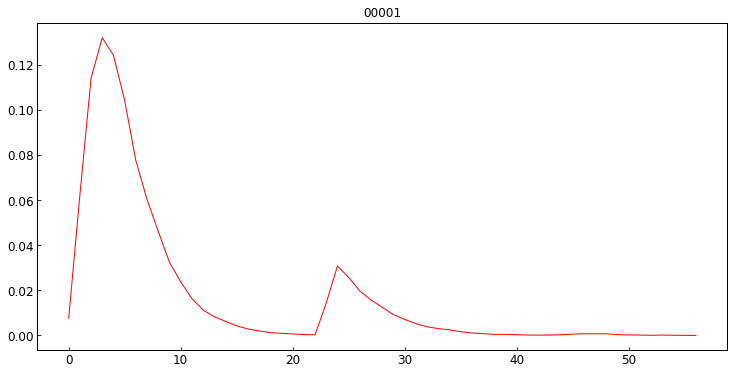

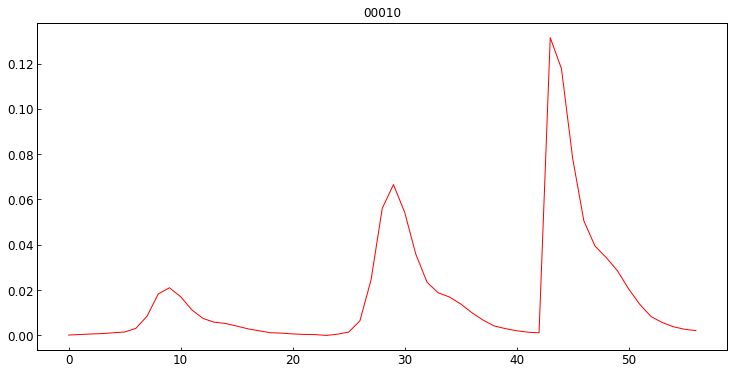

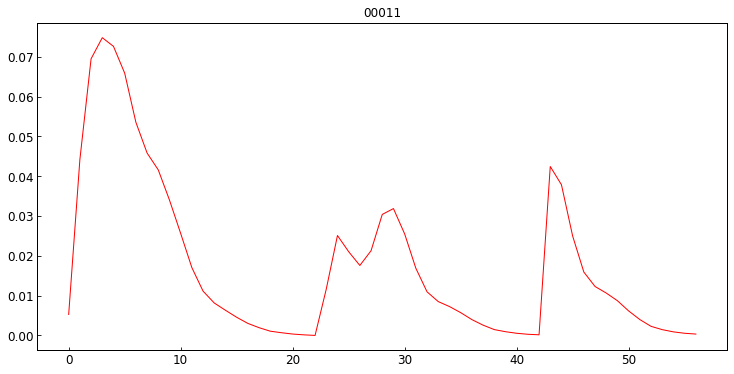

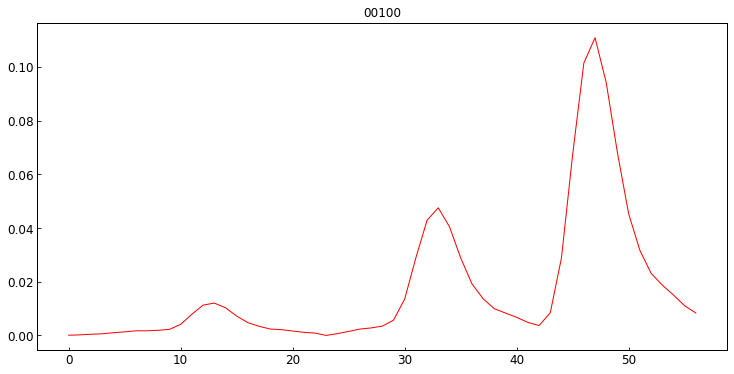

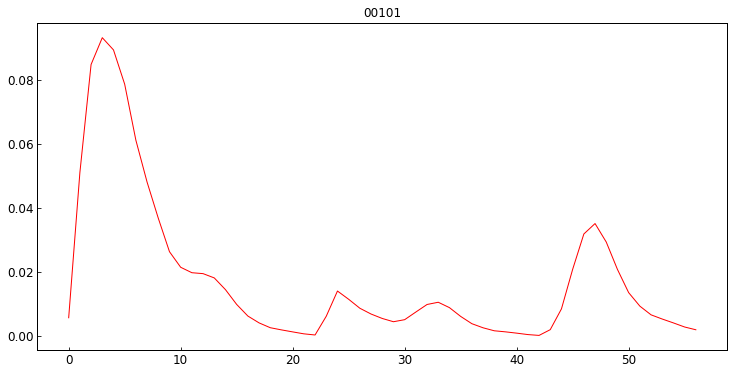

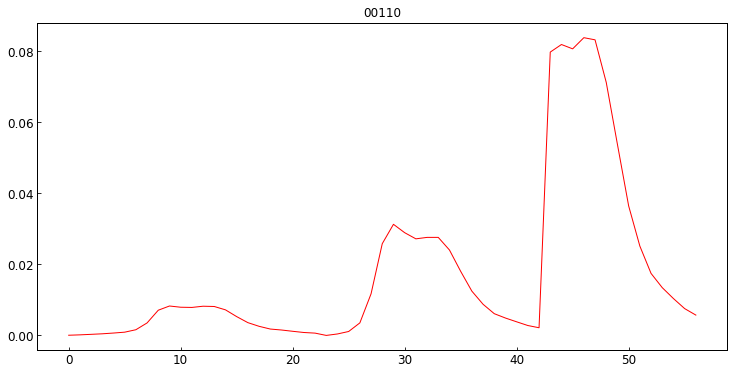

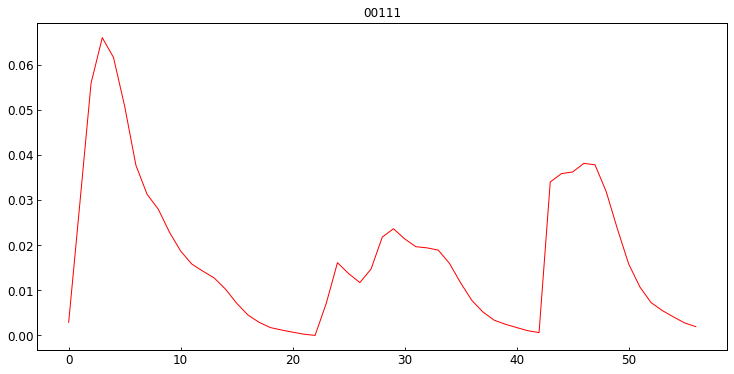

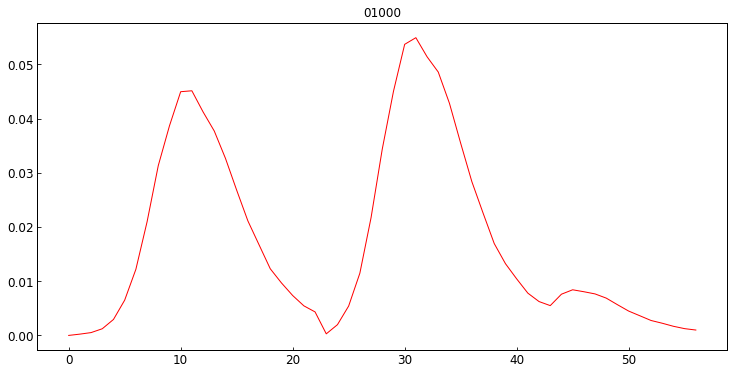

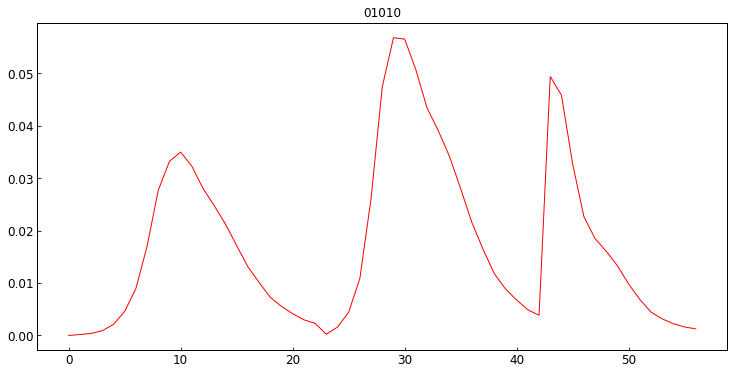

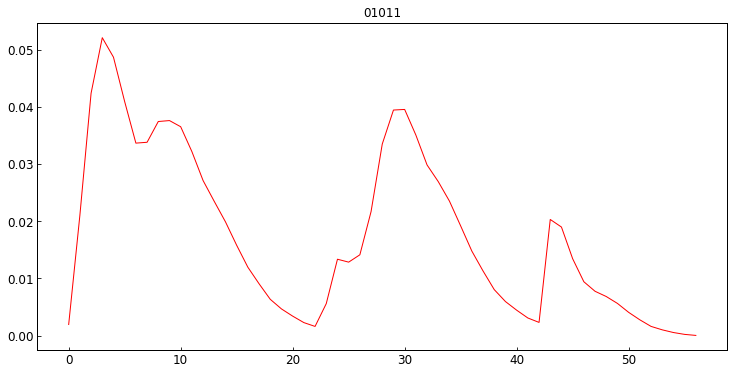

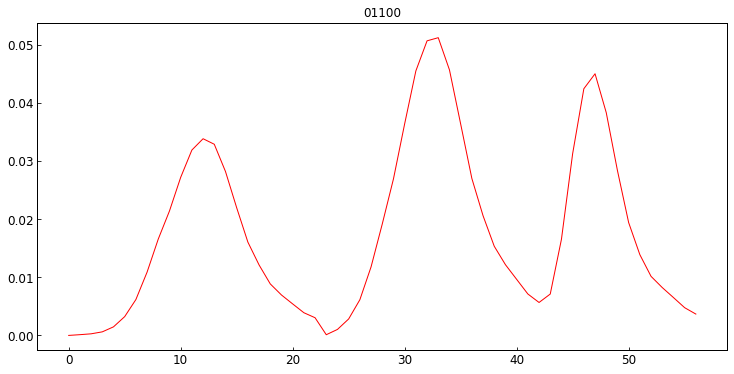

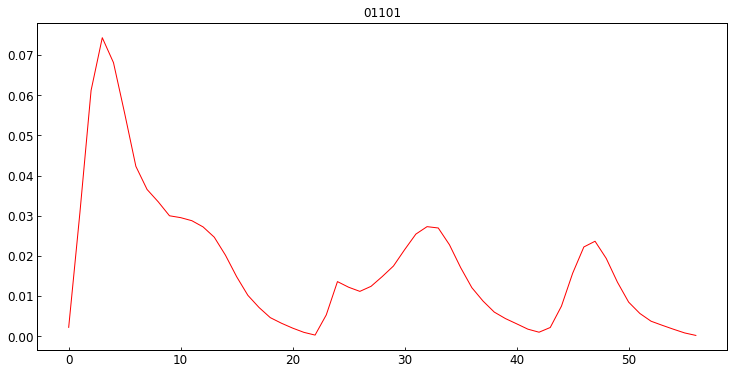

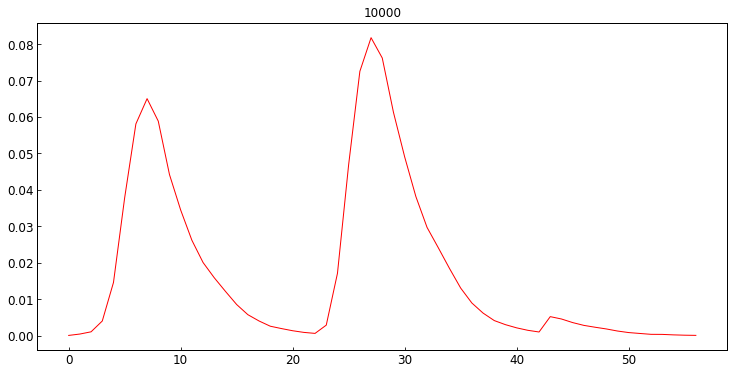

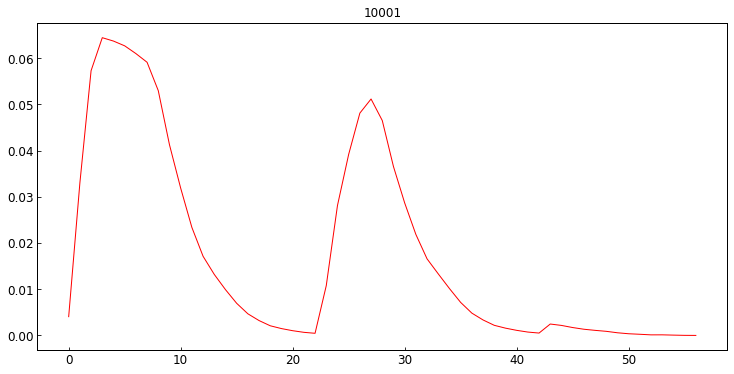

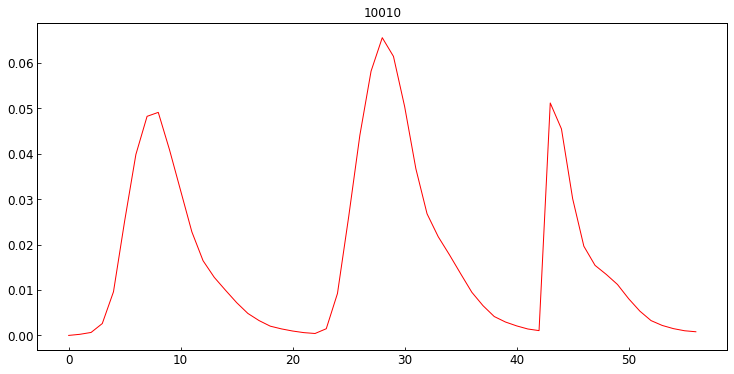

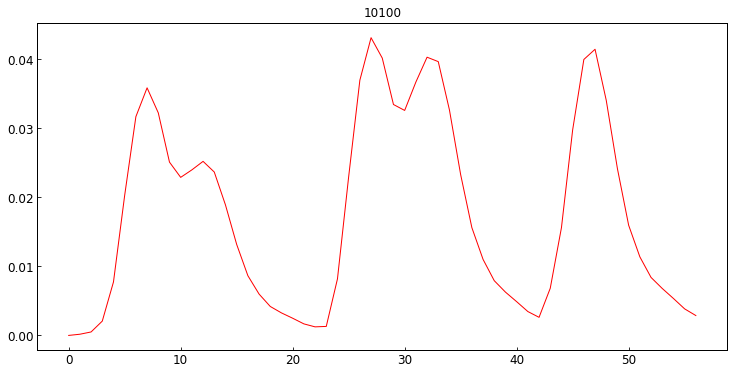

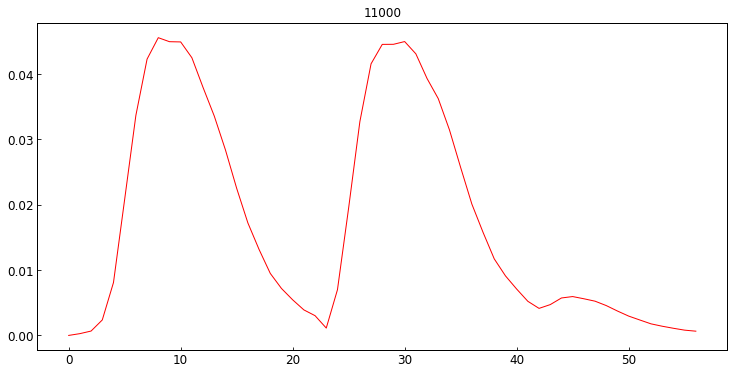

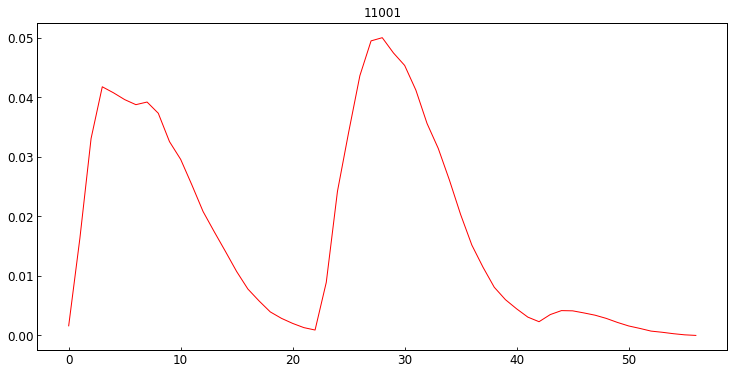

In [19]:
import fn_spectral_images as fsi
import image_plots as ip

for ind, bc in zip(ind_select_sort, bc_select_sort):
    spec = weights_sum_norm[ind]
    fig, ax = ip.general_plot(dims=(10,5))
    fsi.plot_cell_spectra(ax, spec[None,:], {'lw':1,'alpha':1,'color':'r'})
    ax.set_title(bc)

## Design Welch barcode scheme for 5bit

Switch directories

In [20]:
import os

# Absolute path
project_workdir = '/workdir/bmg224/harvard_dental/pick_distant_barcodes'

os.chdir(project_workdir)
os.getcwd()  # Make sure you're in the right directory

'/local/workdir/bmg224/harvard_dental/pick_distant_barcodes'

Load welch probes

In [21]:
welch_probes_fn = 'welch2016_probes.csv'
welch_probes = pd.read_csv(welch_probes_fn, sep='\t')
welch_probes.columns = ['name','taxon','probe','source']
welch_probes

,name,taxon,probe,source
0,Eub338,Bacteria,GCTGCCTCCCGTAGGAGT,44
1,Actinobacteria,NaN,NaN,NaN
2,Act381,Actinobacteria,CGTCGCTGCATCAGGCTT,This paper
3,Act692,Actinobacteria,CTGATATCTGCGCATTCC,This paper
4,Act476,Actinomyces,ATCCAGCTACCGTCAACC,45
5,Cor595,Corynebacterium,CCGGAATTTCACAGACGACG,This paper
6,Cor633,Corynebacterium,AGTTATGCCCGTATCGCCTG,This paper
7,Rot491,Rothia,TAGCCGGCGCTTTCTCTG,16
8,Cmat175,Corynebacterium matruchotii,ACTAAACCATGGTCCTATCCG,This paper
9,Bacteroidetes,NaN,NaN,NaN


List target taxa

In [22]:
from collections import defaultdict

target_taxa = ['Actinomyces','Corynebacterium','Rothia','Capnocytophaga','Prevotella','Porphyromonas','Streptococcus','Gemella','Veillonella','Selenomonas','Lautropia','Neisseriaceae','Pasteurellaceae','Campylobacter','Fusobacterium','Leptotrichia','Treponema','TM7']
dict_tax_probe = defaultdict(list)
dict_tax_probename = defaultdict(list)
for t in target_taxa:
    for i, row in welch_probes.iterrows():
        tax = row['taxon']
        if isinstance(tax, str):
            if t in tax:
                dict_tax_probe[t].append(row['probe'])
                dict_tax_probename[t].append(row['name'])

print(dict_tax_probe)
dict_tax_probename


defaultdict(<class 'list'>, {'Actinomyces': ['ATCCAGCTACCGTCAACC'], 'Corynebacterium': ['CCGGAATTTCACAGACGACG', 'AGTTATGCCCGTATCGCCTG', 'ACTAAACCATGGTCCTATCCG'], 'Rothia': ['TAGCCGGCGCTTTCTCTG'], 'Capnocytophaga': ['TCAGTCTTCCGACCATTG'], 'Prevotella': ['GCACGCTACTTGGCTGG'], 'Porphyromonas': ['CCTCACGCCTTACGACGG'], 'Streptococcus': ['TAGCCGTCCCTTTCTGGT'], 'Gemella': ['TAAACCACCTGCGCGCGCTT'], 'Veillonella': ['CCGTGGCTTTCTATTCCG'], 'Selenomonas': ['TCATTCGCTCCGTTCGAC'], 'Lautropia': ['TGGCACAGTCCTTTTCGTTCC'], 'Neisseriaceae': ['CCTGTGTTACGGCTCCCG'], 'Pasteurellaceae': ['TCCCAAGCATTACTCACC'], 'Campylobacter': ['ATTTCTGCAAGCAGACACTC'], 'Fusobacterium': ['GGCTTCCCCATCGGCATT'], 'Leptotrichia': ['GCCTAGATGCCCTTTATG'], 'Treponema': ['TCTACAGATTCCACCCCTAC'], 'TM7': ['CCCAGTCACTCCGGATAA']})


defaultdict(list,
            {'Actinomyces': ['Act476'],
             'Corynebacterium': ['Cor595', 'Cor633', 'Cmat175'],
             'Rothia': ['Rot491'],
             'Capnocytophaga': ['Cap371'],
             'Prevotella': ['Prv392'],
             'Porphyromonas': ['Pg1160'],
             'Streptococcus': ['Str405'],
             'Gemella': ['Gem572'],
             'Veillonella': ['Vei488'],
             'Selenomonas': ['Sel60'],
             'Lautropia': ['Lmir444'],
             'Neisseriaceae': ['Nei1030'],
             'Pasteurellaceae': ['Pas111'],
             'Campylobacter': ['Cam1021'],
             'Fusobacterium': ['Fus714'],
             'Leptotrichia': ['Lep568'],
             'Treponema': ['Trp684'],
             'TM7': ['TM7550']})

Load hiprfish flanking regions

In [23]:
hipr_flanking_fn = 'hiprfish_flanking_regions.csv'
hipr_flanking = pd.read_csv(hipr_flanking_fn)
hipr_flanking

,flanking,sequence
0,MERFISH_R1,TGTGGAGGGATTGAAGGATA
1,MERFISH_R2,ATAGGAAATGGTGGTAGTGT
2,MERFISH_R3,AGAGTGAGTAGTAGTGGAGT
3,MERFISH_R4,TGTGATGGAAGTTAGAGGGT
4,MERFISH_R5,TGAAAGGAATGGGTTGTGGT
5,MERFISH_R6,TTGGAGGTGTAGGGAGTAAA
6,MERFISH_R7,AGGGTGTGTTTGTAAAGGGT
7,MERFISH_R8,AGGTTAGGTTGAGAATAGGA
8,MERFISH_R9,TAGAGTTGATAGAGGGAGAA
9,MERFISH_R10,GATGATGTAGTAGTAAGGGT


Barcode bit dictionary

In [24]:
dict_bit_seq = {}
for i, j in enumerate([9,7,2,1,0]):
    dict_bit_seq[i] = hipr_flanking.loc[j,'sequence']

dict_bit_seq

{0: 'GATGATGTAGTAGTAAGGGT',
 1: 'AGGTTAGGTTGAGAATAGGA',
 2: 'AGAGTGAGTAGTAGTGGAGT',
 3: 'ATAGGAAATGGTGGTAGTGT',
 4: 'TGTGGAGGGATTGAAGGATA'}

Load the old design

In [25]:
old_design_fn = 'welch2016_5b_no_633_channel.csv'

old_design = pd.read_csv(old_design_fn)
old_design

,sci_name,target_taxon,probe_id,probe_full_seq,code
0,Streptococcus,1301,Str405_001,TAGCCGTCCCTTTCTGGTTGTGGAGGGATTGAAGGATA,1
1,Neisseria,482,Nei1030_002,CCTGTGTTACGGCTCCCGATAGGAAATGGTGGTAGTGT,10
2,Veillonella,29465,Vei488_004,CCGTGGCTTTCTATTCCGAGAGTGAGTAGTAGTGGAGT,100
3,Rothia,32207,Rot491_032,TAGCCGGCGCTTTCTCTGAGGTTAGGTTGAGAATAGGA,1000
4,Actinomyces,1654,Act476_064,ATCCAGCTACCGTCAACCGATGATGTAGTAGTAAGGGT,10000
5,Selenomonas,970,Sel60_007_01,TCATTCGCTCCGTTCGACTGTGGAGGGATTGAAGGATA,111
6,Selenomonas,970,Sel60_007_02,TCATTCGCTCCGTTCGACATAGGAAATGGTGGTAGTGT,111
7,Selenomonas,970,Sel60_007_03,TCATTCGCTCCGTTCGACAGAGTGAGTAGTAGTGGAGT,111
8,Campylobacter,194,Cam1021_035_01,ATTTCTGCAAGCAGACACTCTGTGGAGGGATTGAAGGATA,1011
9,Campylobacter,194,Cam1021_035_02,ATTTCTGCAAGCAGACACTCATAGGAAATGGTGGTAGTGT,1011


Get dict of old barcodes

In [37]:
dict_tax_bc_old = {}
for i, row in old_design.iterrows():
    dict_tax_bc_old[row['sci_name']] = row['code']

dict_tax_bc_old

{'Streptococcus': 1,
 'Neisseria': 10,
 'Veillonella': 100,
 'Rothia': 1000,
 'Actinomyces': 10000,
 'Selenomonas': 111,
 'Campylobacter': 1011,
 'Corynebacterium': 10011,
 'Saccharibacteria': 11001,
 'Leptotrichia': 11010,
 'Lautropia': 11100,
 'Pasteurellaceae': 10110,
 'Porphyromonas': 10101,
 'Capnocytophaga': 1101,
 'Prevotella': 1110,
 'Gemella': 11111,
 'Treponema': 11,
 'Fusobacterium': 1001}

In [38]:
# Convert names to the same
dict_tax_bc_old['Neisseriaceae'] = dict_tax_bc_old['Neisseria']
del dict_tax_bc_old['Neisseria']
dict_tax_bc_old['TM7'] = dict_tax_bc_old['Saccharibacteria']
del dict_tax_bc_old['Saccharibacteria']
dict_tax_bc_old

{'Streptococcus': 1,
 'Veillonella': 100,
 'Rothia': 1000,
 'Actinomyces': 10000,
 'Selenomonas': 111,
 'Campylobacter': 1011,
 'Corynebacterium': 10011,
 'Leptotrichia': 11010,
 'Lautropia': 11100,
 'Pasteurellaceae': 10110,
 'Porphyromonas': 10101,
 'Capnocytophaga': 1101,
 'Prevotella': 1110,
 'Gemella': 11111,
 'Treponema': 11,
 'Fusobacterium': 1001,
 'Neisseriaceae': 10,
 'TM7': 11001}

Assign new barcodes and ensure there are no barcodes that are the same as the old barcodes

In [64]:
# Write new barcodes 
import random 

bc_select_int = [int(bc) for bc in bc_select_sort]
taxa = list(dict_tax_probename.keys())
random.shuffle(taxa)
for tax in taxa:
    bc = bc_select_int[0]
    bc_old = dict_tax_bc_old[tax]
    if bc == bc_old:
        bc = bc_select_int[1] 
        del bc_select_int[1]
    else:
        del bc_select_int[0]
    dict_tax_bc_new[tax] = bc

dict_tax_bc_new

{'Actinomyces': 1010,
 'Corynebacterium': 1,
 'Rothia': 11000,
 'Capnocytophaga': 10001,
 'Prevotella': 1000,
 'Porphyromonas': 10,
 'Streptococcus': 110,
 'Gemella': 10100,
 'Veillonella': 111,
 'Selenomonas': 11,
 'Lautropia': 1100,
 'Neisseriaceae': 10010,
 'Pasteurellaceae': 101,
 'Campylobacter': 10000,
 'Fusobacterium': 1011,
 'Leptotrichia': 100,
 'Treponema': 11001,
 'TM7': 1101}

In [71]:
dict_tax_bc_new_sort = {k: dict_tax_bc_new[k] for k in sorted(list(dict_tax_bc_new.keys()))}
dict_tax_bc_new_sort

{'Actinomyces': 1010,
 'Campylobacter': 10000,
 'Capnocytophaga': 10001,
 'Corynebacterium': 1,
 'Fusobacterium': 1011,
 'Gemella': 10100,
 'Lautropia': 1100,
 'Leptotrichia': 100,
 'Neisseriaceae': 10010,
 'Pasteurellaceae': 101,
 'Porphyromonas': 10,
 'Prevotella': 1000,
 'Rothia': 11000,
 'Selenomonas': 11,
 'Streptococcus': 110,
 'TM7': 1101,
 'Treponema': 11001,
 'Veillonella': 111}

Iterate through old barcodes and reassign if not in new design

In [103]:
# bc_select_int = [int(bc) for bc in bc_select_sort]

# dict_tax_bc_new = {}
# for key, value in dict_tax_bc_old.items():
#     if value in bc_select_int:
#         dict_tax_bc_new[key] = value
#         print(key, value)
#         bc_select_int.remove(value)
#     else:
#         dict_tax_bc_new[key] = bc_select_int[0]
#         del bc_select_int[0]

# dict_tax_bc_new['Neisseriaceae'] = dict_tax_bc_new['Neisseria']
# del dict_tax_bc_new['Neisseria']
# dict_tax_bc_new['TM7'] = dict_tax_bc_new['Saccharibacteria']
# del dict_tax_bc_new['Saccharibacteria']
# dict_tax_bc_new


Streptococcus 1
Neisseria 10
Veillonella 100
Rothia 1000
Actinomyces 10000
Selenomonas 111
Saccharibacteria 11001
Lautropia 11100
Pasteurellaceae 10110
Capnocytophaga 1101


{'Streptococcus': 1,
 'Veillonella': 100,
 'Rothia': 1000,
 'Actinomyces': 10000,
 'Selenomonas': 111,
 'Campylobacter': 11,
 'Corynebacterium': 101,
 'Leptotrichia': 110,
 'Lautropia': 11100,
 'Pasteurellaceae': 10110,
 'Porphyromonas': 1010,
 'Capnocytophaga': 1101,
 'Prevotella': 1100,
 'Gemella': 1111,
 'Treponema': 10001,
 'Fusobacterium': 11000,
 'Neisseriaceae': 10,
 'TM7': 11001}

Append flanking regions to sequences

In [116]:
dict_tax_probe_flank = {}
for tax, bc in dict_tax_bc_new.items():
    probes = dict_tax_probe[tax]
    names = dict_tax_probename[tax]
    dict_ = {}
    for p, n in zip(probes, names):
        dict_[n] = []
        for i, bit in enumerate(str(bc).zfill(5)):
            if int(bit):
                probe_flank = p + dict_bit_seq[i]
                dict_[n].append([probe_flank, 5-i])
    dict_tax_probe_flank[tax] = dict_

dict_tax_probe_flank


{'Streptococcus': {'Str405': [['TAGCCGTCCCTTTCTGGTAGAGTGAGTAGTAGTGGAGT', 3],
   ['TAGCCGTCCCTTTCTGGTATAGGAAATGGTGGTAGTGT', 2],
   ['TAGCCGTCCCTTTCTGGTTGTGGAGGGATTGAAGGATA', 1]]},
 'Veillonella': {'Vei488': [['CCGTGGCTTTCTATTCCGAGGTTAGGTTGAGAATAGGA', 4],
   ['CCGTGGCTTTCTATTCCGATAGGAAATGGTGGTAGTGT', 2]]},
 'Rothia': {'Rot491': [['TAGCCGGCGCTTTCTCTGATAGGAAATGGTGGTAGTGT', 2],
   ['TAGCCGGCGCTTTCTCTGTGTGGAGGGATTGAAGGATA', 1]]},
 'Actinomyces': {'Act476': [['ATCCAGCTACCGTCAACCTGTGGAGGGATTGAAGGATA', 1]]},
 'Selenomonas': {'Sel60': [['TCATTCGCTCCGTTCGACAGGTTAGGTTGAGAATAGGA', 4],
   ['TCATTCGCTCCGTTCGACAGAGTGAGTAGTAGTGGAGT', 3]]},
 'Campylobacter': {'Cam1021': [['ATTTCTGCAAGCAGACACTCGATGATGTAGTAGTAAGGGT', 5],
   ['ATTTCTGCAAGCAGACACTCTGTGGAGGGATTGAAGGATA', 1]]},
 'Corynebacterium': {'Cor595': [['CCGGAATTTCACAGACGACGATAGGAAATGGTGGTAGTGT',
    2]],
  'Cor633': [['AGTTATGCCCGTATCGCCTGATAGGAAATGGTGGTAGTGT', 2]],
  'Cmat175': [['ACTAAACCATGGTCCTATCCGATAGGAAATGGTGGTAGTGT', 2]]},
 'Leptotrichia': {'L

Make probe design file

In [134]:
df_tax_bc = pd.DataFrame({'sci_name': dict_tax_bc_new.keys(), 'code': dict_tax_bc_new.values()})
new_design_5b_fn = 'welch2016_5b_distant.csv'
df_tax_bc.to_csv(new_design_5b_fn, index=False)
df_tax_bc


,sci_name,code
0,Streptococcus,111
1,Veillonella,1010
2,Rothia,11
3,Actinomyces,1
4,Selenomonas,1100
5,Campylobacter,10001
6,Corynebacterium,10
7,Leptotrichia,11000
8,Lautropia,1101
9,Pasteurellaceae,10000


Make IDT order file

In [118]:
names = []
seqs = []
for tax, probes_flank in dict_tax_probe_flank.items():
    probe_names = dict_tax_probename[tax]
    bc = dict_tax_bc_new[tax]
    bc_b10 = int(str(bc),2)
    for n, seq in probes_flank.items():
        for s in seq:
            name = n + '_bc' + str(bc_b10) + '_fl' + str(s[1])
            names.append(name)
            seqs.append(s[0])

df_idt = pd.DataFrame({'Name':names, 'Sequence':seqs})
df_idt['Scale'] = '25nm'
df_idt['Purification'] = 'STD'

df_idt_fn = 'welch2016_5b_distant_IDT_v3.csv'
df_idt.to_csv(df_idt_fn, index=False)
df_idt



,Name,Sequence,Scale,Purification
0,Str405_bc7_fl3,TAGCCGTCCCTTTCTGGTAGAGTGAGTAGTAGTGGAGT,25nm,STD
1,Str405_bc7_fl2,TAGCCGTCCCTTTCTGGTATAGGAAATGGTGGTAGTGT,25nm,STD
2,Str405_bc7_fl1,TAGCCGTCCCTTTCTGGTTGTGGAGGGATTGAAGGATA,25nm,STD
3,Vei488_bc10_fl4,CCGTGGCTTTCTATTCCGAGGTTAGGTTGAGAATAGGA,25nm,STD
4,Vei488_bc10_fl2,CCGTGGCTTTCTATTCCGATAGGAAATGGTGGTAGTGT,25nm,STD
5,Rot491_bc3_fl2,TAGCCGGCGCTTTCTCTGATAGGAAATGGTGGTAGTGT,25nm,STD
6,Rot491_bc3_fl1,TAGCCGGCGCTTTCTCTGTGTGGAGGGATTGAAGGATA,25nm,STD
7,Act476_bc1_fl1,ATCCAGCTACCGTCAACCTGTGGAGGGATTGAAGGATA,25nm,STD
8,Sel60_bc12_fl4,TCATTCGCTCCGTTCGACAGGTTAGGTTGAGAATAGGA,25nm,STD
9,Sel60_bc12_fl3,TCATTCGCTCCGTTCGACAGAGTGAGTAGTAGTGGAGT,25nm,STD


## Adjust 5b design for two flanking regions

Get old barcode dict

In [72]:
# dict_tax_bc_newish = {
#     'Streptococcus':'111',
#     'Veillonella':'1010',
#     'Rothia':'11',
#     'Actinomyces':'1',
#     'Selenomonas':'1100',
#     'Campylobacter':'10001',
#     'Corynebacterium':'10',
#     'Leptotrichia':'11000',
#     'Lautropia':'1101',
#     'Pasteurellaceae':'10000',
#     'Porphyromonas':'110',
#     'Capnocytophaga':'100',
#     'Prevotella':'101',
#     'Gemella':'1000',
#     'Treponema':'11001',
#     'Fusobacterium':'10110',
#     'Neisseriaceae':'1111',
#     'TM7':'11100'
# }
# dict_tax_bc_newish = {k:v.zfill(5) for k, v in dict_tax_bc_newish.items()}
# dict_tax_bc_newish_sort = {k: (dict_tax_bc_newish[k]) for k in sorted(list(dict_tax_bc_newish.keys()))}

# dict_tax_bc_newish_sort

{'Actinomyces': '00001',
 'Campylobacter': '10001',
 'Capnocytophaga': '00100',
 'Corynebacterium': '00010',
 'Fusobacterium': '10110',
 'Gemella': '01000',
 'Lautropia': '01101',
 'Leptotrichia': '11000',
 'Neisseriaceae': '01111',
 'Pasteurellaceae': '10000',
 'Porphyromonas': '00110',
 'Prevotella': '00101',
 'Rothia': '00011',
 'Selenomonas': '01100',
 'Streptococcus': '00111',
 'TM7': '11100',
 'Treponema': '11001',
 'Veillonella': '01010'}

Plot the spectra

In [ ]:
# dict_bc_ind = dict(zip(barcodes_str, np.arange(len(barcodes_str))))
# dict_bc_ind


Recode Treponema to not be the same code as in distant_v3

In [73]:
dict_tax_bc_new['Treponema'] = 111
dict_tax_bc_new['Veillonella'] = 11001

# for sci_name, bc in dict_tax_bc_new.items():
#     ind = dict_bc_ind[bc]
#     spec = weights_sum_norm[ind]
#     fig, ax = ip.general_plot(dims=(10,5))
#     fsi.plot_cell_spectra(ax, spec[None,:], {'lw':1,'alpha':1,'color':'r'})
#     ax.set_title(sci_name)

Append flanking regions to sequences

In [77]:
dict_tax_probe_flank = {}
for tax, bc in dict_tax_bc_new.items():
    probes = dict_tax_probe[tax]
    names = dict_tax_probename[tax]
    dict_ = {}
    for p, n in zip(probes, names):
        dict_[n] = []
        bc_ = str(bc).zfill(5)
        flanks = []
        flank_inds = []
        for i, bit in enumerate(bc_):
            if int(bit):
                flanks.append(dict_bit_seq[i])
                flank_inds.append(i)
        flanks_append = flanks + flanks[:1]
        flank_inds_append = flank_inds + flank_inds[:1]
        for i in range(len(flanks)):
            f0 = flanks_append[i]
            f1 = flanks_append[i+1]
            i0 = flank_inds_append[i]
            i1 = flank_inds_append[i+1]
            probe_flank = f0 + ' ' + p + ' ' + f1
            dict_[n].append([probe_flank, 5 - i0, 5 - i1])
    dict_tax_probe_flank[tax] = dict_

dict_tax_probe_flank


{'Actinomyces': {'Act476': [['AGGTTAGGTTGAGAATAGGA ATCCAGCTACCGTCAACC ATAGGAAATGGTGGTAGTGT',
    4,
    2],
   ['ATAGGAAATGGTGGTAGTGT ATCCAGCTACCGTCAACC AGGTTAGGTTGAGAATAGGA', 2, 4]]},
 'Corynebacterium': {'Cor595': [['TGTGGAGGGATTGAAGGATA CCGGAATTTCACAGACGACG TGTGGAGGGATTGAAGGATA',
    1,
    1]],
  'Cor633': [['TGTGGAGGGATTGAAGGATA AGTTATGCCCGTATCGCCTG TGTGGAGGGATTGAAGGATA',
    1,
    1]],
  'Cmat175': [['TGTGGAGGGATTGAAGGATA ACTAAACCATGGTCCTATCCG TGTGGAGGGATTGAAGGATA',
    1,
    1]]},
 'Rothia': {'Rot491': [['GATGATGTAGTAGTAAGGGT TAGCCGGCGCTTTCTCTG AGGTTAGGTTGAGAATAGGA',
    5,
    4],
   ['AGGTTAGGTTGAGAATAGGA TAGCCGGCGCTTTCTCTG GATGATGTAGTAGTAAGGGT', 4, 5]]},
 'Capnocytophaga': {'Cap371': [['GATGATGTAGTAGTAAGGGT TCAGTCTTCCGACCATTG TGTGGAGGGATTGAAGGATA',
    5,
    1],
   ['TGTGGAGGGATTGAAGGATA TCAGTCTTCCGACCATTG GATGATGTAGTAGTAAGGGT', 1, 5]]},
 'Prevotella': {'Prv392': [['AGGTTAGGTTGAGAATAGGA GCACGCTACTTGGCTGG AGGTTAGGTTGAGAATAGGA',
    4,
    4]]},
 'Porphyromonas': {'Pg1160': 

Make probe design file

In [78]:
df_tax_bc = pd.DataFrame({'sci_name': dict_tax_bc_new.keys(), 'code': dict_tax_bc_new.values()})
new_design_5b_fn = 'welch2016_5b_distant_v4_doubleflank.csv'
df_tax_bc.to_csv(new_design_5b_fn, index=False)
df_tax_bc


,sci_name,code
0,Actinomyces,1010
1,Corynebacterium,1
2,Rothia,11000
3,Capnocytophaga,10001
4,Prevotella,1000
5,Porphyromonas,10
6,Streptococcus,110
7,Gemella,10100
8,Veillonella,11001
9,Selenomonas,11


Make IDT order file

In [79]:
names = []
seqs = []
for tax, probes_flank in dict_tax_probe_flank.items():
    probe_names = dict_tax_probename[tax]
    bc = dict_tax_bc_new[tax]
    bc_b10 = int(str(bc),2)
    for n, seq in probes_flank.items():
        for s in seq:
            name = n + '_fl_' + str(s[1]) + '_' + str(s[2])
            names.append(name)
            seqs.append(s[0])

df_idt = pd.DataFrame({'Name':names, 'Sequence':seqs})
df_idt['Scale'] = '25nm'
df_idt['Purification'] = 'STD'

df_idt_fn = 'welch2016_5b_distant_IDT_v4_doubleflank.csv'
df_idt.to_csv(df_idt_fn, index=False)
df_idt



,Name,Sequence,Scale,Purification
0,Act476_fl_4_2,AGGTTAGGTTGAGAATAGGA ATCCAGCTACCGTCAACC ATAGGA...,25nm,STD
1,Act476_fl_2_4,ATAGGAAATGGTGGTAGTGT ATCCAGCTACCGTCAACC AGGTTA...,25nm,STD
2,Cor595_fl_1_1,TGTGGAGGGATTGAAGGATA CCGGAATTTCACAGACGACG TGTG...,25nm,STD
3,Cor633_fl_1_1,TGTGGAGGGATTGAAGGATA AGTTATGCCCGTATCGCCTG TGTG...,25nm,STD
4,Cmat175_fl_1_1,TGTGGAGGGATTGAAGGATA ACTAAACCATGGTCCTATCCG TGT...,25nm,STD
5,Rot491_fl_5_4,GATGATGTAGTAGTAAGGGT TAGCCGGCGCTTTCTCTG AGGTTA...,25nm,STD
6,Rot491_fl_4_5,AGGTTAGGTTGAGAATAGGA TAGCCGGCGCTTTCTCTG GATGAT...,25nm,STD
7,Cap371_fl_5_1,GATGATGTAGTAGTAAGGGT TCAGTCTTCCGACCATTG TGTGGA...,25nm,STD
8,Cap371_fl_1_5,TGTGGAGGGATTGAAGGATA TCAGTCTTCCGACCATTG GATGAT...,25nm,STD
9,Prv392_fl_4_4,AGGTTAGGTTGAGAATAGGA GCACGCTACTTGGCTGG AGGTTAG...,25nm,STD


## Apply to 7bit reference barcodes

Get all 7 bit barcodes as base 10

In [165]:
b = [0,1]
barcodes_str = []
for i in b:
    bc0 = str(i)
    for j in b:
        bc1 = bc0 + str(j)
        for k in b:
            bc2 = bc1 + str(k)
            for l in b:
                bc3 = bc2 + str(l)
                for m in b:
                    bc4 = bc3 + str(m)
                    for n in b:
                        bc5 = bc4 + str(n)
                        for o in b:
                            bc6 = bc5 + str(o)
                            barcodes_str.append(bc6)
barcodes_str = barcodes_str[1:-1]
print(len(barcodes_str))
barcodes_str[:10]
               

126


['0000001',
 '0000010',
 '0000011',
 '0000100',
 '0000101',
 '0000110',
 '0000111',
 '0001000',
 '0001001',
 '0001010']

Load average reference spectra

In [166]:
import pandas as pd

ref_dir = '/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/data/unused/fig_5/HiPRFISH_reference_spectra'
fmt = '08_18_2018_enc_{}_avgint.csv'

barcodes_10bit = [bc[0] + '0' + bc[1:4] + '00' + bc[4:] for bc in barcodes_str]
# barcodes_10bit = [bc[0] + '0' + bc[1:4] + '00' + bc[4:] for bc in barcodes_str]
barcodes_b10 = [int(str(bc),2) for bc in barcodes_10bit]
ref_chan_start = 32
chan_start = 0
chan_end = 63

st = ref_chan_start + chan_start
en = ref_chan_start + chan_end
ref_avgint_cols = [i for i in range(st,en)]

ref_spec = []
for bc in barcodes_b10:
    fn = ref_dir + '/'+ fmt.format(bc)
    ref = pd.read_csv(fn, header=None)
    ref = ref[ref_avgint_cols].values
    ref_spec.append(ref)

print(barcodes_10bit[:10])

['0000000001', '0000000010', '0000000011', '0000000100', '0000000101', '0000000110', '0000000111', '0000100000', '0000100001', '0000100010']


Normlize reference spectra

In [167]:
ref_norm = [r / np.max(r, axis=1)[:,None] for r in ref_spec]
weights_max_norm = [np.mean(r, axis=0) for r in ref_norm]

ref_sum_norm = []
for r in ref_spec:
    r_ = r - np.min(r, axis=1)[:,None]
    ref_sum_norm.append(r_ / np.sum(r_, axis=1)[:,None])
weights_sum_norm = [np.mean(r, axis=0) for r in ref_sum_norm]

Measure distance between each spectrum and the others

In [168]:
N = len(barcodes_str)

d_mat = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if i < j:
            spec_i = weights_sum_norm[i]
            spec_j = weights_sum_norm[j]
            d_mat[i,j] = fhc.euclid_dist_cumul_spec(spec_i, spec_j)

Dictionary for accessing distances 

In [169]:
dict_ij_dist = {}
for i in range(N):
    for j in range(N):
        if i < j:
            key = str(i) + '_' + str(j)
            dict_ij_dist[key] = d_mat[i,j]


Initialize the set k

In [170]:
k = 18

bcs = []
unselected = np.arange(N).astype(int).tolist()
for i in range(k):
    bc = np.random.choice(unselected, 1)[0]
    bcs.append(bc)
    unselected.remove(bc)
bcs

[118, 58, 87, 7, 17, 63, 9, 10, 64, 66, 98, 39, 101, 50, 91, 119, 32, 92]

Create a dictionary indicating the minimum distance for each k_i

In [171]:
dict_k_mindist = {}
for i in bcs:
    dists = []
    for j in bcs:
        if i != j:
            if i < j:
                key = str(i) + '_' + str(j)
            else:
                key = str(j) + '_' + str(i)
            dists.append(dict_ij_dist[key])
    dict_k_mindist[i] = min(dists)
dict_k_mindist

{118: 0.058957793021464415,
 58: 0.022142507523391308,
 87: 0.07401813031627956,
 7: 0.2678693815419027,
 17: 0.10146862961843672,
 63: 0.09598983587664305,
 9: 0.10927113204271817,
 10: 0.08259601207417969,
 64: 0.04143242656489327,
 66: 0.04143242656489327,
 98: 0.05991044439219238,
 39: 0.08964995449792518,
 101: 0.07767834612767101,
 50: 0.022142507523391308,
 91: 0.0664777198508998,
 119: 0.0664777198508998,
 32: 0.06791173154169755,
 92: 0.044641285981235665}

Iterate replacing the k_i that has the smallest distance with a random selection from the remaining N if the random selection has a larger min distance with the rest of k_j not equals i.

In [172]:

iterations = 1000000
for i in range(iterations):

    # Extrac the k_i with smallest distance
    k_ind = np.where(min(dict_k_mindist.values()))[0][0]
    ks = list(dict_k_mindist.keys())
    old = ks[k_ind]
    dist_min_old = dict_k_mindist[old]
    del dict_k_mindist[old]

    # Pick a random new choice and calculate the min distance to the remaining k
    new = np.random.choice(unselected, 1)[0]
    dists = []
    for j in ks:
        if new < j:
            ij_key = str(new) + '_' + str(j)
        else:
            ij_key = str(j) + '_' + str(new)
        dists.append(dict_ij_dist[ij_key])
    dist_min_new = min(dists)

    # Replace the old k_i if the new one has a larger min distance
    if dist_min_new > dist_min_old:
        dict_k_mindist[new] = dist_min_new
        unselected.remove(new)
        unselected.append(old)
    else:
        dict_k_mindist[old] = dist_min_old

dict_k_mindist
    

{1: 0.12858049967253107,
 69: 0.12303883145244075,
 63: 0.11176619362633068,
 19: 0.10826844318818656,
 0: 0.1439156405408622,
 11: 0.12022847974680627,
 9: 0.10927113204271817,
 79: 0.12774715812302304,
 15: 0.24083446540729492,
 85: 0.10292251639154885,
 4: 0.10197338958867258,
 7: 0.2678693815419027,
 25: 0.10976761697161068,
 44: 0.10137404763778464,
 3: 0.13065642619920953,
 24: 0.1120210377016685,
 72: 0.1166397861936185,
 39: 0.10985090616564464}

Convert index back to barcodes

In [173]:
index_select = list(dict_k_mindist.keys())

barcodes_select = []
for ind in index_select:
    barcodes_select.append(barcodes_str[ind])

barcodes_select

['0000010',
 '1000110',
 '1000000',
 '0010100',
 '0000001',
 '0001100',
 '0001010',
 '1010000',
 '0010000',
 '1010110',
 '0000101',
 '0001000',
 '0011010',
 '0101101',
 '0000100',
 '0011001',
 '1001001',
 '0101000']

In [174]:
bc_select_sort = sorted(barcodes_select)

ind_select_sort = [x for _, x in sorted(zip(barcodes_select, index_select))]

print(bc_select_sort)

['0000001', '0000010', '0000100', '0000101', '0001000', '0001010', '0001100', '0010000', '0010100', '0011001', '0011010', '0101000', '0101101', '1000000', '1000110', '1001001', '1010000', '1010110']


Plot spectra

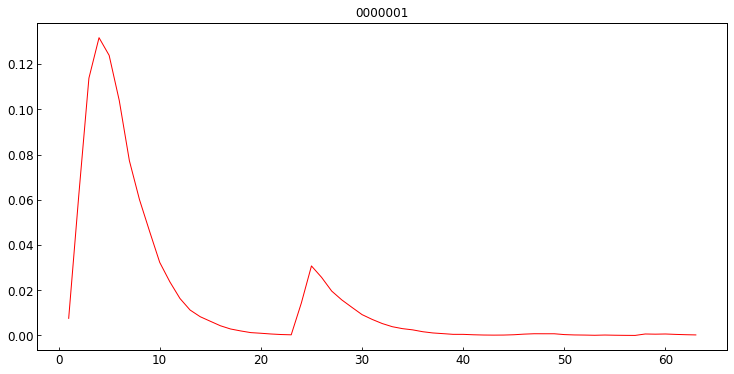

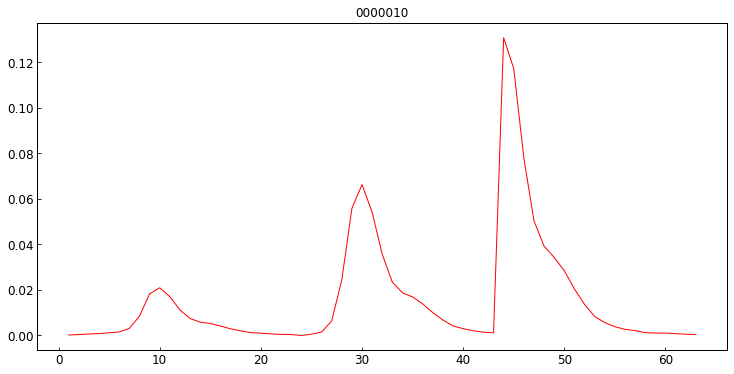

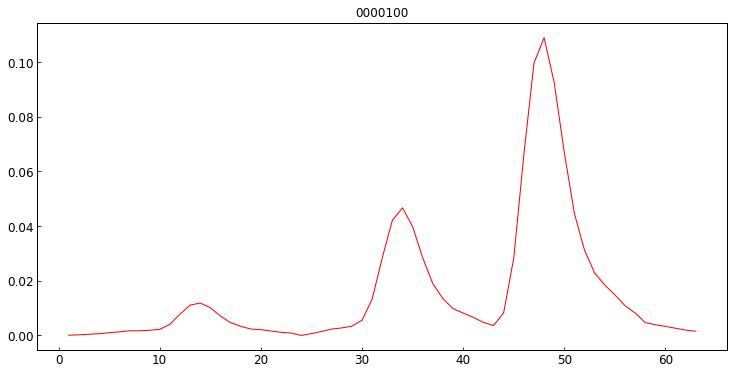

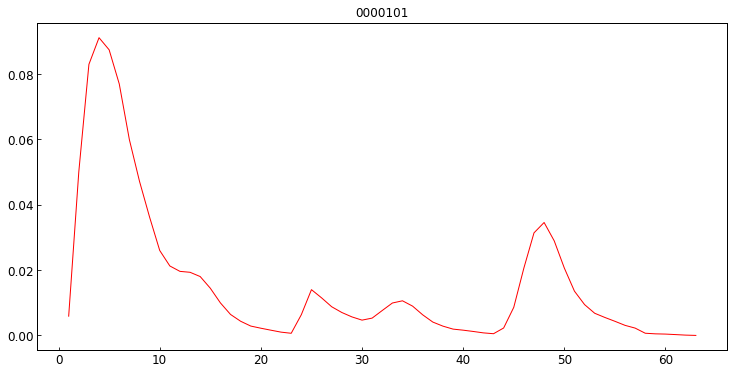

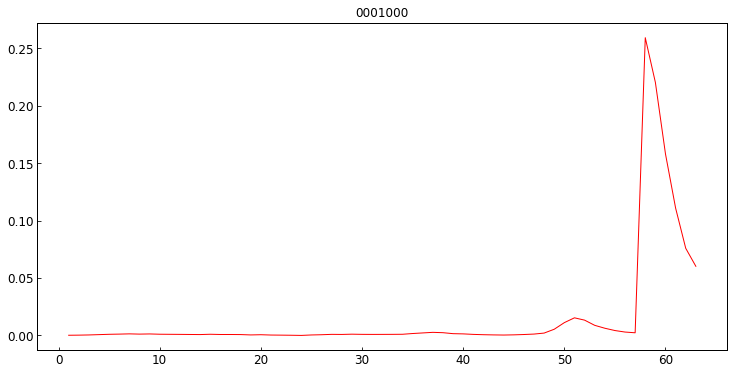

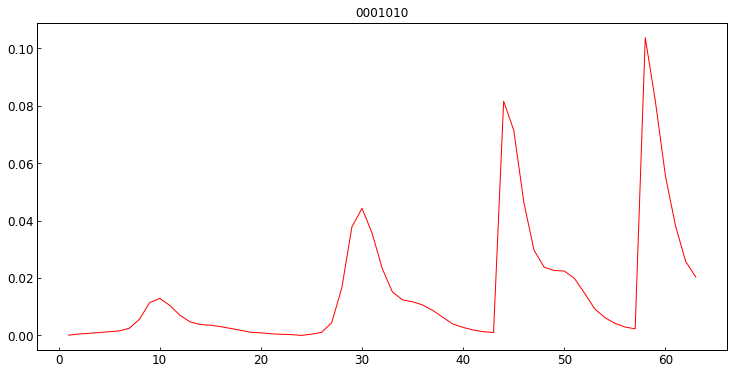

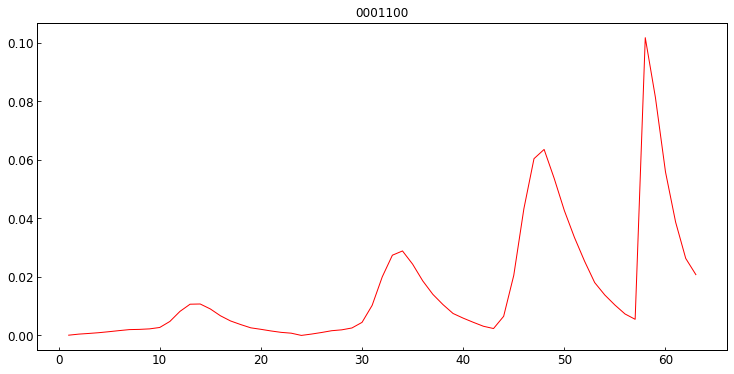

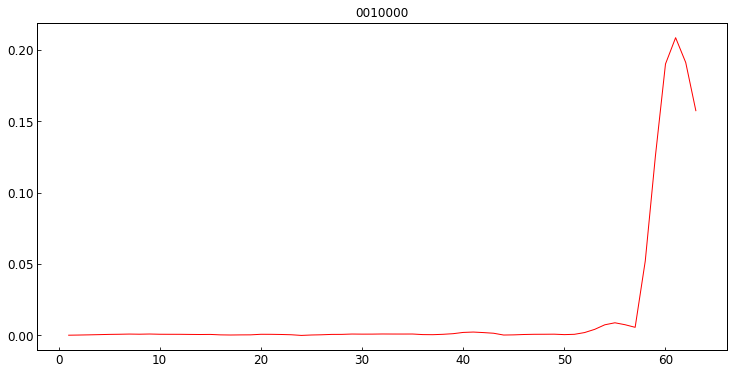

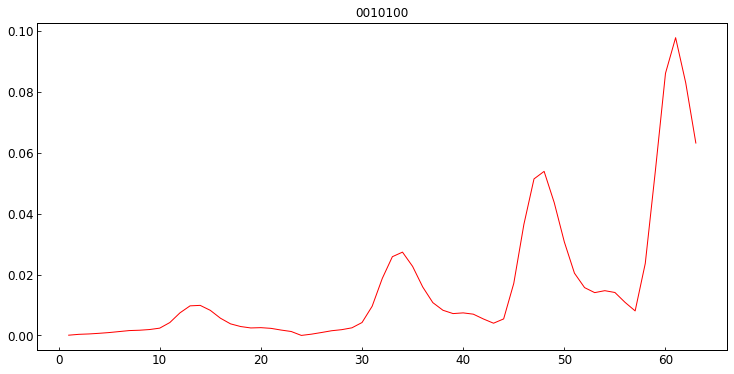

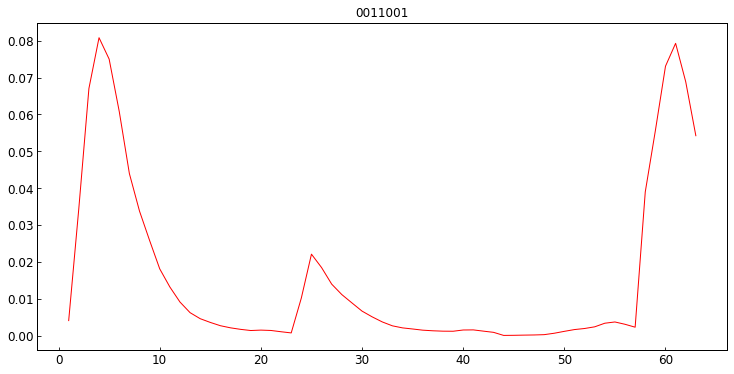

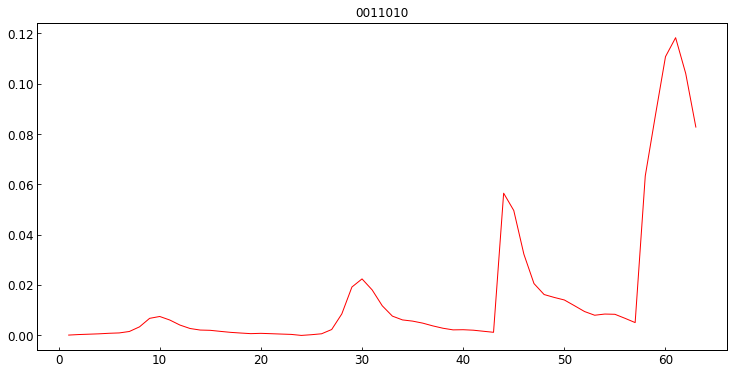

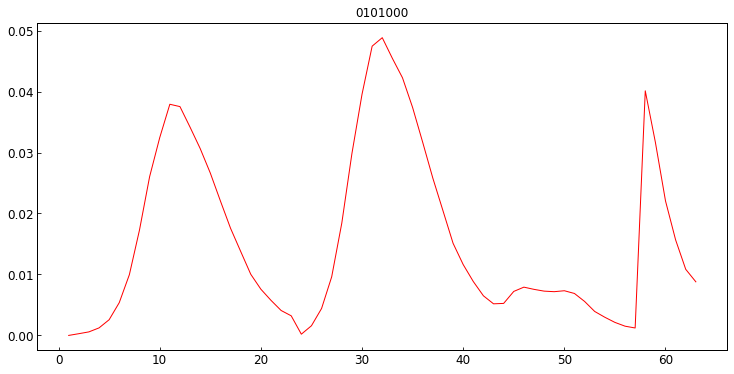

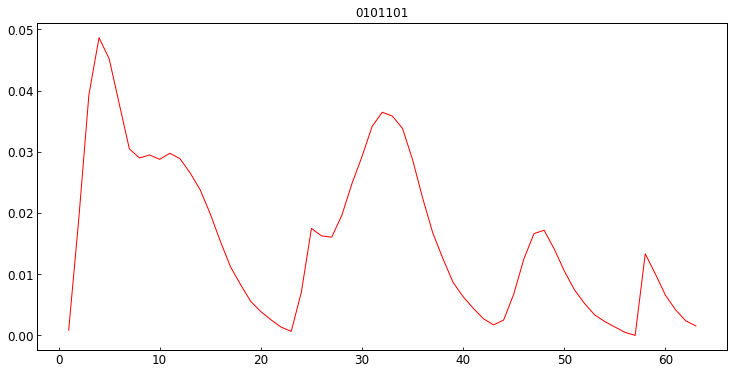

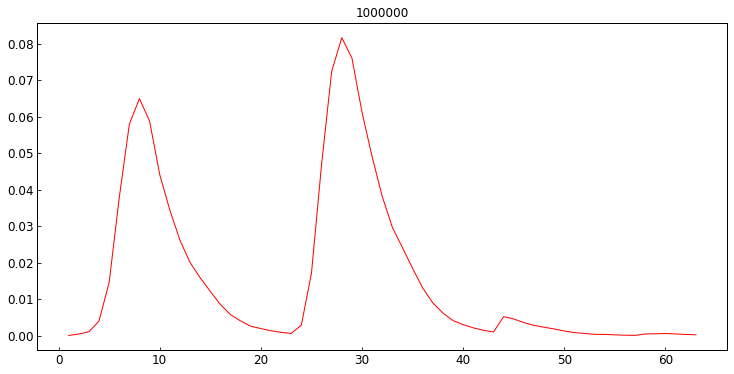

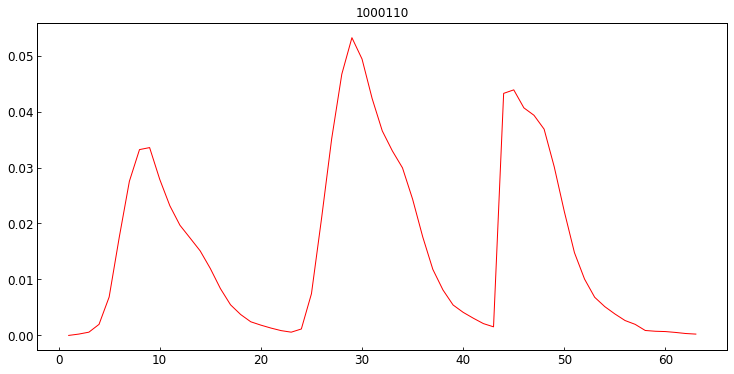

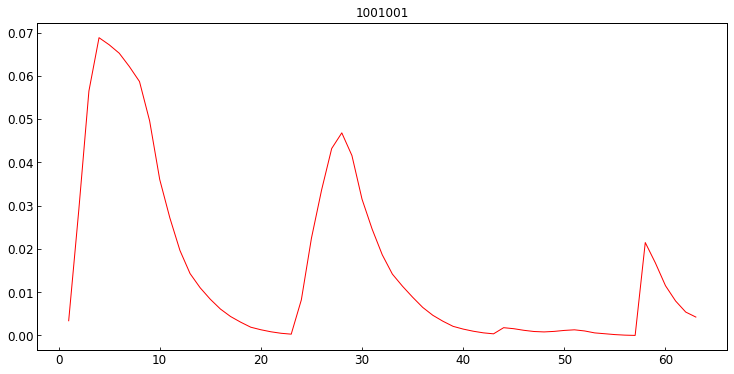

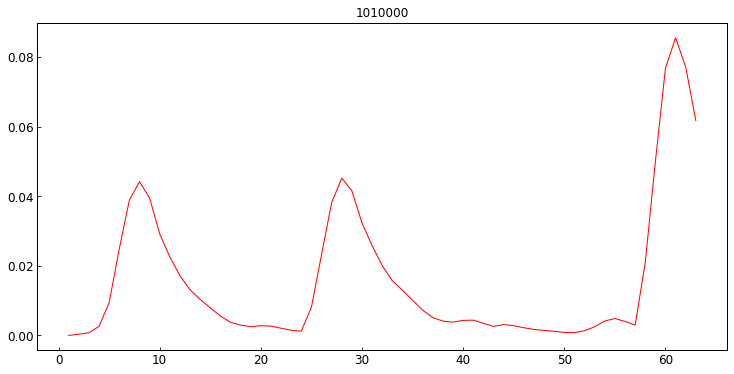

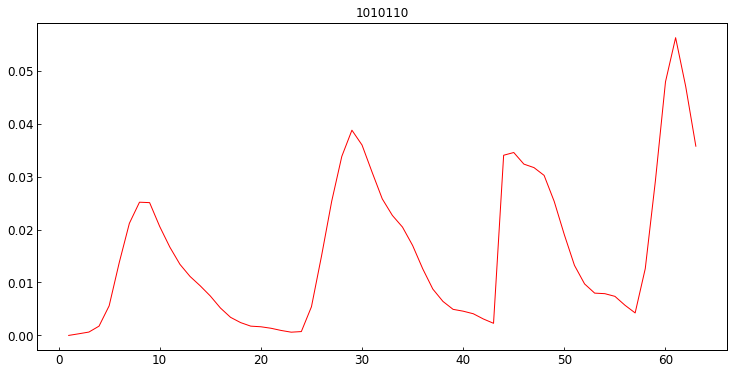

In [175]:
import fn_spectral_images as fsi
import image_plots as ip

for ind, bc in zip(ind_select_sort, bc_select_sort):
    spec = weights_sum_norm[ind]
    fig, ax = ip.general_plot(dims=(10,5))
    fsi.plot_cell_spectra(ax, spec[None,:], {'lw':1,'alpha':1,'color':'r'})
    ax.set_title(bc)

## Design Welch barcode scheme for 7bit

Barcode bit dictionary

In [176]:
dict_bit_seq = {}
for i, j in enumerate([9,7,6,5,2,1,0]):
    dict_bit_seq[i] = hipr_flanking.loc[j,'sequence']

dict_bit_seq

{0: 'GATGATGTAGTAGTAAGGGT',
 1: 'AGGTTAGGTTGAGAATAGGA',
 2: 'AGGGTGTGTTTGTAAAGGGT',
 3: 'TTGGAGGTGTAGGGAGTAAA',
 4: 'AGAGTGAGTAGTAGTGGAGT',
 5: 'ATAGGAAATGGTGGTAGTGT',
 6: 'TGTGGAGGGATTGAAGGATA'}

Assign new barcodes and ensure there are no barcodes that are the same as the old barcodes

In [177]:
df_tax_bc_new_5b = pd.read_csv(new_design_5b_fn)
dict_tax_bc_new_5b = dict(zip(df_tax_bc_new_5b.sci_name, df_tax_bc_new_5b.code))
dict_tax_bc_new_5b

{'Streptococcus': 1111,
 'Veillonella': 10001,
 'Rothia': 1000,
 'Actinomyces': 1,
 'Selenomonas': 10100,
 'Campylobacter': 1000001,
 'Corynebacterium': 10,
 'Leptotrichia': 1010110,
 'Lautropia': 11010,
 'Pasteurellaceae': 1000000,
 'Porphyromonas': 1100,
 'Capnocytophaga': 100,
 'Prevotella': 1010,
 'Gemella': 10000,
 'Treponema': 1011000,
 'Fusobacterium': 1000100,
 'Neisseriaceae': 101000,
 'TM7': 1110001}

In [178]:
# Write new barcodes 
bc_select_int = [int(bc) for bc in bc_select_sort]

def to_7bit_fr_5b(bc):
    bc = str(bc).zfill(5)
    bc = bc[0] + '0' + bc[1] + '00' + bc[2:]
    return int(bc)

dict_tax_bc_old_7b = {k: to_7bit_fr_5b(v) for k,v in dict_tax_bc_old.items()}
dict_tax_bc_new_5b_7b = {k: to_7bit_fr_5b(v) for k,v in dict_tax_bc_new_5b.items()}

for tax in dict_tax_probename.keys():
    bc = bc_select_int[0]
    bc_old = dict_tax_bc_old_7b[tax]
    bc_new5b = dict_tax_bc_new_5b_7b[tax]
    if (bc == bc_old) or (bc == bc_new5b):
        bc = bc_select_int[1] 
        del bc_select_int[1]
    else:
        del bc_select_int[0]
    dict_tax_bc_new[tax] = bc

dict_tax_bc_new

{'Streptococcus': 1100,
 'Veillonella': 10100,
 'Rothia': 100,
 'Actinomyces': 10,
 'Selenomonas': 11001,
 'Campylobacter': 1000000,
 'Corynebacterium': 1,
 'Leptotrichia': 1001001,
 'Lautropia': 11010,
 'Pasteurellaceae': 101101,
 'Porphyromonas': 1010,
 'Capnocytophaga': 101,
 'Prevotella': 1000,
 'Gemella': 10000,
 'Treponema': 1010000,
 'Fusobacterium': 1000110,
 'Neisseriaceae': 101000,
 'TM7': 1010110}

Append flanking regions to sequences

In [179]:
nbit=7

dict_tax_probe_flank = {}
for tax, bc in dict_tax_bc_new.items():
    probes = dict_tax_probe[tax]
    names = dict_tax_probename[tax]
    dict_ = {}
    for p, n in zip(probes, names):
        dict_[n] = []
        for i, bit in enumerate(str(bc).zfill(nbit)):
            if int(bit):
                probe_flank = p + dict_bit_seq[i]
                dict_[n].append([probe_flank, nbit-i])
    dict_tax_probe_flank[tax] = dict_

dict_tax_probe_flank


{'Streptococcus': {'Str405': [['TAGCCGTCCCTTTCTGGTTTGGAGGTGTAGGGAGTAAA', 4],
   ['TAGCCGTCCCTTTCTGGTAGAGTGAGTAGTAGTGGAGT', 3]]},
 'Veillonella': {'Vei488': [['CCGTGGCTTTCTATTCCGAGGGTGTGTTTGTAAAGGGT', 5],
   ['CCGTGGCTTTCTATTCCGAGAGTGAGTAGTAGTGGAGT', 3]]},
 'Rothia': {'Rot491': [['TAGCCGGCGCTTTCTCTGAGAGTGAGTAGTAGTGGAGT', 3]]},
 'Actinomyces': {'Act476': [['ATCCAGCTACCGTCAACCATAGGAAATGGTGGTAGTGT', 2]]},
 'Selenomonas': {'Sel60': [['TCATTCGCTCCGTTCGACAGGGTGTGTTTGTAAAGGGT', 5],
   ['TCATTCGCTCCGTTCGACTTGGAGGTGTAGGGAGTAAA', 4],
   ['TCATTCGCTCCGTTCGACTGTGGAGGGATTGAAGGATA', 1]]},
 'Campylobacter': {'Cam1021': [['ATTTCTGCAAGCAGACACTCGATGATGTAGTAGTAAGGGT',
    7]]},
 'Corynebacterium': {'Cor595': [['CCGGAATTTCACAGACGACGTGTGGAGGGATTGAAGGATA',
    1]],
  'Cor633': [['AGTTATGCCCGTATCGCCTGTGTGGAGGGATTGAAGGATA', 1]],
  'Cmat175': [['ACTAAACCATGGTCCTATCCGTGTGGAGGGATTGAAGGATA', 1]]},
 'Leptotrichia': {'Lep568': [['GCCTAGATGCCCTTTATGGATGATGTAGTAGTAAGGGT', 7],
   ['GCCTAGATGCCCTTTATGTTGGAGGTGTAGGGAGTAA

Make probe design file

In [180]:
df_tax_bc = pd.DataFrame({'sci_name': dict_tax_bc_new.keys(), 'code': dict_tax_bc_new.values()})
new_design_5b_fn = 'welch2016_7b_distant.csv'
df_tax_bc.to_csv(new_design_5b_fn, index=False)
df_tax_bc


,sci_name,code
0,Streptococcus,1100
1,Veillonella,10100
2,Rothia,100
3,Actinomyces,10
4,Selenomonas,11001
5,Campylobacter,1000000
6,Corynebacterium,1
7,Leptotrichia,1001001
8,Lautropia,11010
9,Pasteurellaceae,101101


Make IDT order file

In [182]:
names = []
seqs = []
for tax, probes_flank in dict_tax_probe_flank.items():
    probe_names = dict_tax_probename[tax]
    bc = dict_tax_bc_new[tax]
    bc_b10 = int(str(bc),2)
    for n, seq in probes_flank.items():
        for s in seq:
            name = n + '_bc' + str(bc_b10) + '_fl' + str(s[1])
            names.append(name)
            seqs.append(s[0])

df_idt = pd.DataFrame({'Name':names, 'Sequence':seqs})
df_idt['Scale'] = '25nm'
df_idt['Purification'] = 'STD'

df_idt_fn = 'welch2016_7b_distant_IDT_v2.csv'
df_idt.to_csv(df_idt_fn, index=False)
df_idt



,Name,Sequence,Scale,Purification
0,Str405_bc12_fl4,TAGCCGTCCCTTTCTGGTTTGGAGGTGTAGGGAGTAAA,25nm,STD
1,Str405_bc12_fl3,TAGCCGTCCCTTTCTGGTAGAGTGAGTAGTAGTGGAGT,25nm,STD
2,Vei488_bc20_fl5,CCGTGGCTTTCTATTCCGAGGGTGTGTTTGTAAAGGGT,25nm,STD
3,Vei488_bc20_fl3,CCGTGGCTTTCTATTCCGAGAGTGAGTAGTAGTGGAGT,25nm,STD
4,Rot491_bc4_fl3,TAGCCGGCGCTTTCTCTGAGAGTGAGTAGTAGTGGAGT,25nm,STD
5,Act476_bc2_fl2,ATCCAGCTACCGTCAACCATAGGAAATGGTGGTAGTGT,25nm,STD
6,Sel60_bc25_fl5,TCATTCGCTCCGTTCGACAGGGTGTGTTTGTAAAGGGT,25nm,STD
7,Sel60_bc25_fl4,TCATTCGCTCCGTTCGACTTGGAGGTGTAGGGAGTAAA,25nm,STD
8,Sel60_bc25_fl1,TCATTCGCTCCGTTCGACTGTGGAGGGATTGAAGGATA,25nm,STD
9,Cam1021_bc64_fl7,ATTTCTGCAAGCAGACACTCGATGATGTAGTAGTAAGGGT,25nm,STD
